# Mini Project: Bank Marketing Data

## Preparation

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one
contact to the same client was required, in order to access if the product (bank term
deposit) would be (’yes’) or not (’no’) subscribed.

In [ ]:
#import linear algebra and data manipulation libraries
import numpy as np
import pandas as pd

#import standard visualization
import matplotlib.pyplot as plt
import seaborn as sns

#import machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import xgboost

from sklearn.model_selection import train_test_split #split
from sklearn.metrics import accuracy_score #metrics

#tools for hyperparameters search
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import os


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# import data
bank_train = pd.read_csv("BankMarketing_training.csv")
bank_test = pd.read_csv("BankMarketing_testing.csv")
# view the data
bank_train.head(), bank_test.head()

(   Unnamed: 0  age          job  ... euribor3m nr.employed   y
 0       29023   37  blue-collar  ...     1.405      5099.1  no
 1       37067   27      student  ...     1.029      5076.2  no
 2       10378   45   management  ...     4.960      5228.1  no
 3       25506   34   technician  ...     4.120      5195.8  no
 4       28132   55   management  ...     1.466      5099.1  no
 
 [5 rows x 22 columns],
    Unnamed: 0  age          job  ... euribor3m nr.employed   y
 0           1   30  blue-collar  ...     1.313      5099.1  no
 1           2   39     services  ...     4.855      5191.0  no
 2           3   25     services  ...     4.962      5228.1  no
 3           4   38     services  ...     4.959      5228.1  no
 4           5   47       admin.  ...     4.191      5195.8  no
 
 [5 rows x 22 columns])

In [ ]:
# get rid of the ID column
bank_train = bank_train.drop('Unnamed: 0', 1)
bank_test = bank_test.drop('Unnamed: 0', 1)

In [ ]:
# number of rows in dataset
print("Bank marketing dataset consists of {rows} rows.".format(rows = len(bank_train)))
print("Bank marketing dataset consists of {cols} columns.".format(cols = bank_train.shape[1]))

Bank marketing dataset consists of 41188 rows.
Bank marketing dataset consists of 21 columns.


In [ ]:
# find percentage of missing values for each column
train_missing = bank_train.isnull().mean()*100
test_missing = bank_test.isnull().mean()*100
train_missing.sum(), test_missing.sum()

(0.0, 0.0)

There are no missing values.

## Exploratory Data Analysis

### Analysis of the response column

**(a) Briefly summarize the response variable, i.e., proportion of each class of observations (yes vs no) in both training and testing data sets.**

It is very important to look at the response column, which holds the information, which we are going to predict. In our case we should look at 'deposit' column and compare its values to other columns.
First of all we should look at the number of 'yes' and 'no' values in the response column 'deposit'.

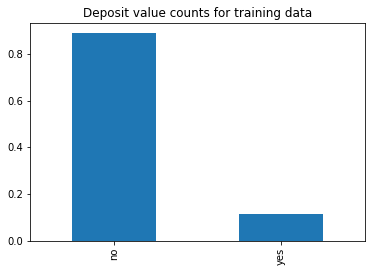

In [ ]:
# plot the proportion of yes and no for training set
train_counts = bank_train['y'].value_counts()/len(bank_train)
train_counts.plot.bar(title = 'Deposit value counts for training data')

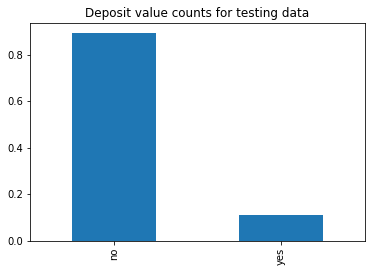

In [ ]:
# do the same for testing set
test_counts = bank_test['y'].value_counts()/len(bank_test)
test_counts.plot.bar(title = "Deposit value counts for testing data")

**As seen from the two charts above, both the training and testing sets have approximately and 90% to 10% split between the no and yes**

### Feature exploration

**(b) Briefly summarize the predictors (in training data set) using appropriate tools.**

In [ ]:
# check the format of the data
bank_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [ ]:
# Examine the range and attribute of each column
bank_train.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Take a look at the values of categorical columns first.

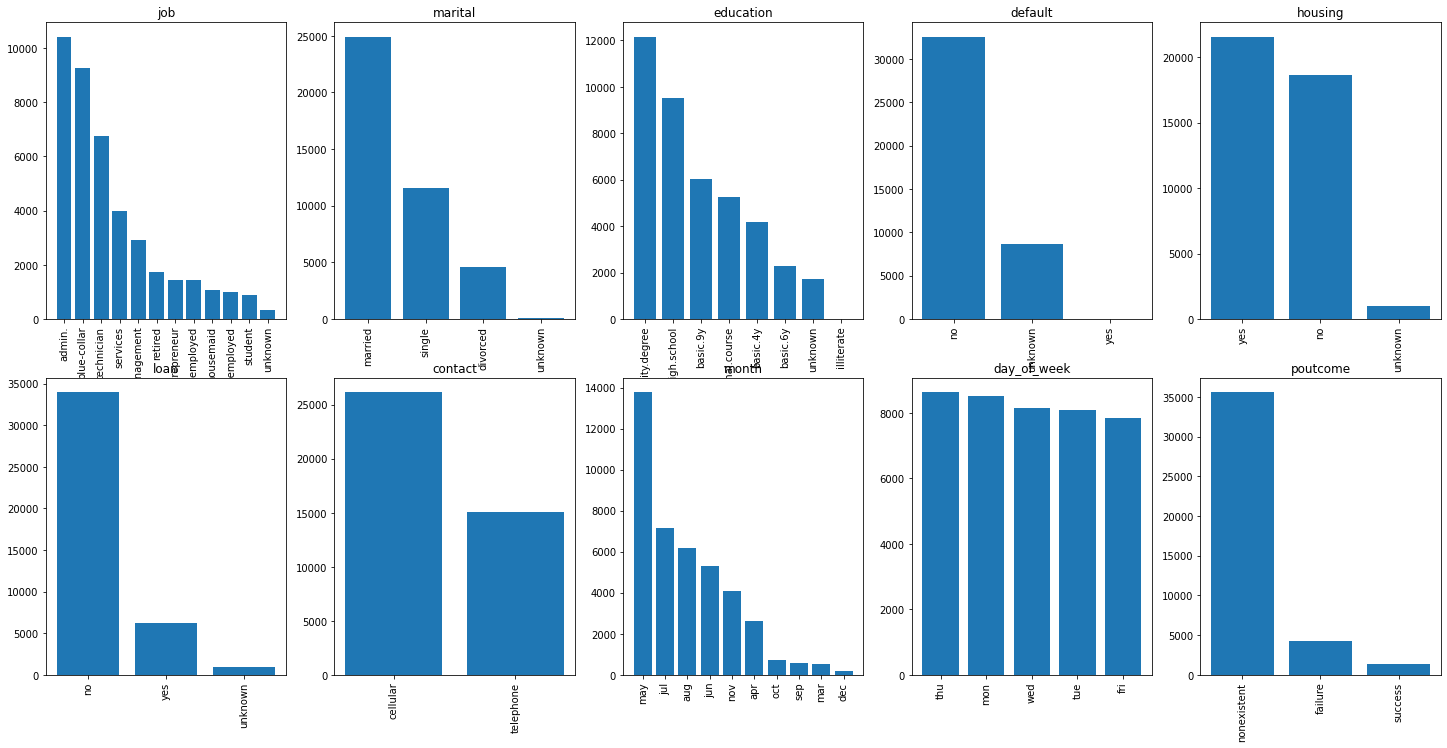

In [ ]:
cat_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
               'contact', 'month','day_of_week', 'poutcome']

fig, axs = plt.subplots(2, 5, sharex=False, sharey=False, figsize=(25, 12))

counter = 0
for cat_column in cat_columns:
    value_counts = bank_train[cat_column].value_counts()
    
    trace_x = counter // 5
    trace_y = counter % 5
    x_pos = np.arange(0, len(value_counts))
    
    axs[trace_x, trace_y].bar(x_pos, value_counts.values, tick_label = value_counts.index)
    
    axs[trace_x, trace_y].set_title(cat_column)
    
    for tick in axs[trace_x, trace_y].get_xticklabels():
        tick.set_rotation(90)
    
    counter += 1

plt.show()

Then take a look at the numerical columns' values. The most convenient way to look at the numerical values is plotting histograms.

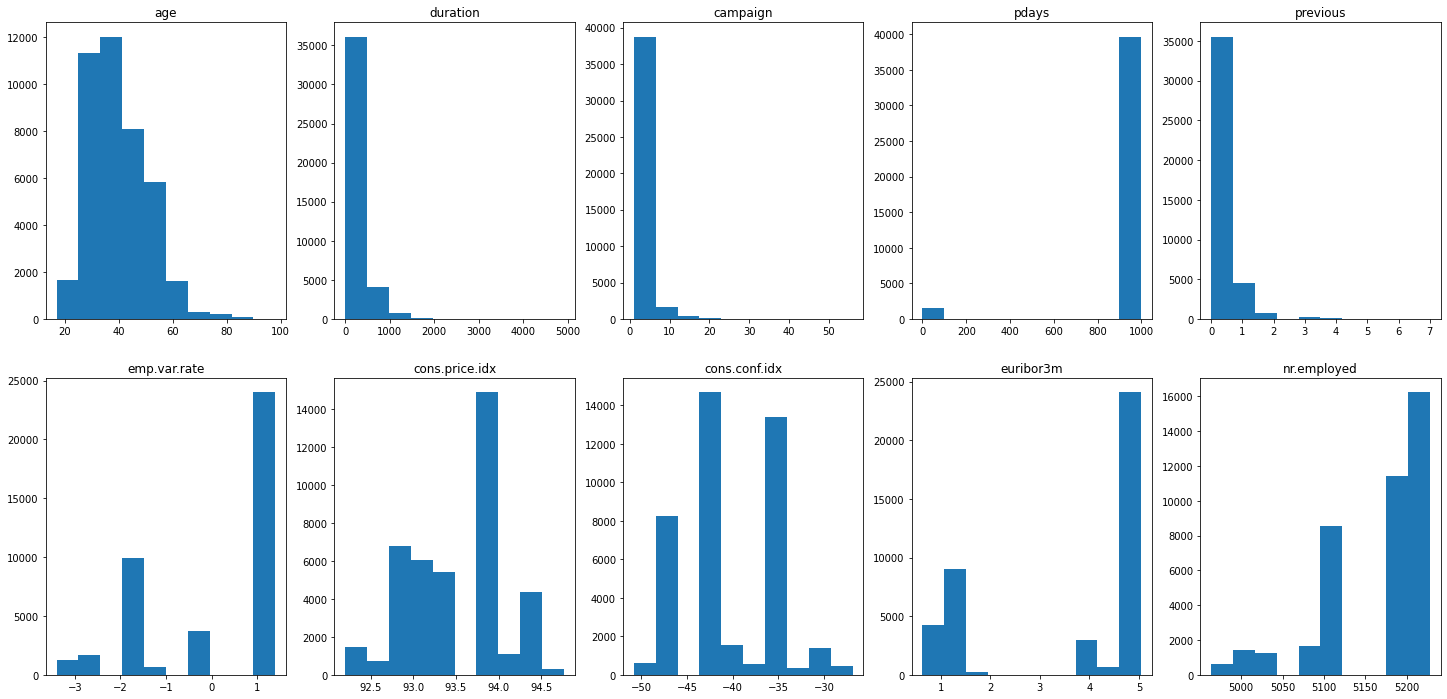

In [ ]:
num_columns = ['age', 'duration', 'campaign', 'pdays', 'previous',
               'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
               'euribor3m', 'nr.employed']

fig, axs = plt.subplots(2, 5, sharex=False, sharey=False, figsize=(25, 12))

counter = 0
for num_column in num_columns:
    
    trace_x = counter // 5
    trace_y = counter % 5
    
    axs[trace_x, trace_y].hist(bank_train[num_column])
    
    axs[trace_x, trace_y].set_title(num_column)
    
    counter += 1

plt.show()

## Modeling and Data Analysis

### Data Cleaning

Before we will be able to apply machine learning techniques, we should prepare the dataset for processing:

1. Convert columns with 'yes' and 'no' values to boolean columns;
2. Convert categorical columns into dummy variables.
3. Extract out all the numerical columns to be used later on

In [ ]:
def get_dummy_from_bool(row, column_name):
    ''' Returns 0 if value in column_name is no, returns 1 if value in column_name is yes'''
    return 1 if row[column_name] == 'yes' else 0

def get_correct_values(row, column_name, threshold, df):
    ''' Returns mean value if value in column_name is above threshold'''
    if row[column_name] <= threshold:
        return row[column_name]
    else:
        mean = df[df[column_name] <= threshold][column_name].mean()
        return mean

def clean_data(df):
    '''
    INPUT
    df - pandas dataframe containing bank marketing campaign dataset
    
    OUTPUT
    df - cleaned dataset:
    1. columns with 'yes' and 'no' values are converted into boolean variables;
    2. categorical columns are converted into dummy variables;
    3. drop irrelevant columns.
    4. impute incorrect values
    '''
    
    cleaned_df = df.copy()
    
    #convert columns containing 'yes' and 'no' values to boolean variables and drop original columns
    bool_columns = ['default', 'housing', 'loan', 'y']
    for bool_col in bool_columns:
        cleaned_df[bool_col + '_bool'] = df.apply(lambda row: get_dummy_from_bool(row, bool_col),axis=1)
    
    cleaned_df = cleaned_df.drop(columns = bool_columns)
    
    #convert categorical columns to dummies
    cat_columns = ['job', 'marital', 'education', 'contact', 
                   'month','day_of_week', 'poutcome']
    
    for col in  cat_columns:
        cleaned_df = pd.concat([cleaned_df.drop(col, axis=1),
                                pd.get_dummies(cleaned_df[col], prefix=col, prefix_sep='_',
                                               drop_first=True, dummy_na=False)], axis=1)
    
    #drop irrelevant columns
    cleaned_df = cleaned_df.drop(columns = ['pdays'])
    
    #impute incorrect values and drop original columns
    cleaned_df['campaign_cleaned'] = df.apply(lambda row: get_correct_values(row, 'campaign', 34, cleaned_df),axis=1)
    cleaned_df['previous_cleaned'] = df.apply(lambda row: get_correct_values(row, 'previous', 34, cleaned_df),axis=1)
    
    cleaned_df = cleaned_df.drop(columns = ['campaign', 'previous'])
    
    return cleaned_df

In [ ]:
# clean the dataset
cleaned_train = clean_data(bank_train)
cleaned_test = clean_data(bank_test)

In [ ]:
# check out the cleaned ones
cleaned_train.shape, cleaned_test.shape 

((41188, 50), (4119, 50))

In [ ]:
# clean the data to be ready for ML algorithm
X_train = cleaned_train.drop('y_bool', axis=1)
y_train = cleaned_train['y_bool']
X_test = cleaned_test.drop('y_bool', axis=1)
y_test = cleaned_test['y_bool']

In [ ]:
# extract out numerical columns
num_train = bank_train[num_columns]
num_test = bank_test[num_columns]

In [ ]:
# get the numerical version ready for analysis
# clean the data to be ready for ML algorithm
X_train_num = num_train
y_train_num = y_train
X_test_num = num_test
y_test_num = y_test

For a classification problem, we usually have following measurements to evaluate the
model performance: \\
**classification accuracy** =num of obs that are correctly classified / total num of obs; \\
**sensitivity** =num of ”yes” obs which are correctly classified as ”yes”/ num of totoal
”yes” obs \\
**specificity** =num of ”no” obs which are correctly classified as ”no”/ num of totoal
”no” obs

### LDA and QDA 

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from imblearn.metrics import sensitivity_specificity_support

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

**(a) Perform LDA and QDA and apply your trained model to the testing set. Report the corresponding accuracy, sensitivity and specificity for testing set predictions.**

#### LDA

In [ ]:
# fit the lda model
lda = LinearDiscriminantAnalysis()
model = lda.fit(X_train, y_train)
pred = model.predict(X_test)
# get the terms from the confusion matrix
cm = confusion_matrix(y_test, pred)
tp = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tn = cm[1][1]
# calculate accuracy, sensitivity, specificity
accuracy_score = (tp+tn)/(tp+fp+fn+tn)
sensitivity = tp/(tp+fn)
specificity = tn/(fp+tn)
# report the corresponing metrics
print("The model has an accuracy of {accu}".format(accu = accuracy_score))
print("The model has a sensitivity score of {sens}".format(sens = sensitivity))
print("The model has a specificity score of {spec}".format(spec = specificity))

The model has an accuracy of 0.9121145909201263
The model has a sensitivity score of 0.9417423837520043
The model has a specificity score of 0.6180371352785146


#### QDA

In [ ]:
# fit the qda model
qda = QuadraticDiscriminantAnalysis()
model = qda.fit(X_train, y_train)
pred = model.predict(X_test)
# get the terms from the confusion matrix
cm = confusion_matrix(y_test, pred)
tp = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tn = cm[1][1]
# calculate accuracy, sensitivity, specificity
accuracy_score = (tp+tn)/(tp+fp+fn+tn)
sensitivity = tp/(tp+fn)
specificity = tn/(fp+tn)
# report the corresponing metrics
print("The model has an accuracy of {accu}".format(accu = accuracy_score))
print("The model has a sensitivity score of {sens}".format(sens = sensitivity))
print("The model has a specificity score of {spec}".format(spec = specificity))

The model has an accuracy of 0.13886865744112648
The model has a sensitivity score of 1.0
The model has a specificity score of 0.1128064032016008


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


**LDA predicted the testing data much better than QDA does.**

### Logit and Linear SVM Classifiers

In [ ]:
# import packages
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

**(b) Perform a logistic regression model and a linear SVM model and apply your trained model on the testing set. Please report the corresponding accuracy, sensitivity and specificity, respectively, for testing set predictions.**

#### Logistic Regression

In [ ]:
# fit the logistic regression model
lrc = LogisticRegression()
model = lrc.fit(X_train, y_train)
pred = model.predict(X_test)
# get the terms from the confusion matrix
cm = confusion_matrix(y_test, pred)
tp = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tn = cm[1][1]
# calculate accuracy, sensitivity, specificity
accuracy_score = (tp+tn)/(tp+fp+fn+tn)
sensitivity = tp/(tp+fn)
specificity = tn/(fp+tn)
# report the corresponing metrics
print("The model has an accuracy of {accu}".format(accu = accuracy_score))
print("The model has a sensitivity score of {sens}".format(sens = sensitivity))
print("The model has a specificity score of {spec}".format(spec = specificity))

The model has an accuracy of 0.9109007040543822
The model has a sensitivity score of 0.9315032679738562
The model has a specificity score of 0.6428571428571429


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


#### SVM

In [ ]:
# fit the SVM model
svm = LinearSVC(random_state=0, tol=1e-5)
model = svm.fit(X_train, y_train)
pred = model.predict(X_test)
# get the terms from the confusion matrix
cm = confusion_matrix(y_test, pred)
tp = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tn = cm[1][1]
# calculate accuracy, sensitivity, specificity
accuracy_score = (tp+tn)/(tp+fp+fn+tn)
sensitivity = tp/(tp+fn)
specificity = tn/(fp+tn)
# report the corresponing metrics
print("The model has an accuracy of {accu}".format(accu = accuracy_score))
print("The model has a sensitivity score of {sens}".format(sens = sensitivity))
print("The model has a specificity score of {spec}".format(spec = specificity))

The model has an accuracy of 0.8907501820830298
The model has a sensitivity score of 0.8914841849148418
The model has a specificity score of 0.5555555555555556


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### None Linear SVM Classifier

In [ ]:
from sklearn.svm import SVC  

**(c) Try a non-linear SVM model and apply your trained model on the testing set. Please report the corresponding accuracy, sensitivity and specificity, respectively, for testing set predictions. Compare your results to those based on a linear SVM model above.**

In [ ]:
# fit the non-linear SVM model
svm = SVC(kernel ='rbf') 
model = svm.fit(X_train, y_train)
pred = model.predict(X_test)
# get the terms from the confusion matrix
cm = confusion_matrix(y_test, pred)
tp = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tn = cm[1][1]
# calculate accuracy, sensitivity, specificity
accuracy_score = (tp+tn)/(tp+fp+fn+tn)
sensitivity = tp/(tp+fn)
specificity = tn/(fp+tn)
# report the corresponing metrics
print("The model has an accuracy of {accu}".format(accu = accuracy_score))
print("The model has a sensitivity score of {sens}".format(sens = sensitivity))
print("The model has a specificity score of {spec}".format(spec = specificity))

The model has an accuracy of 0.8943918426802622
The model has a sensitivity score of 0.8966871165644171
The model has a specificity score of 0.6818181818181818


### Compare Results

**(d) Compare the prediction results of all above models, which one is better? Do you think the LDA and QDA models are appropriate here? Why?**

Clearly Logistic regression is the winner among all other classifiers with an accuracy of more than 90%. I don't think that LDA and QDA are the most appropriate to use in this case for the following reasons. Discriminant analysis assumes a multivariate normal distribution because what we usually consider to be predictors are really a multivariate dependent variable, and the grouping variable is considered to be a predictor. This means that categorical variables that are to be treated as predictors in the sense you wish are not handled well. This is one reason that many, including myself, consider discriminant analysis to have been made obsolete by logistic regression. Logistic regression makes no distributional assumptions of any kind, on either the left hand or the right hand side of the model. Logistic regression is a direct probability model and doesn't require one to use Bayes' rule to convert results to probabilities as does discriminant analysis.

### Re-Fit everything on the numerical data

**(e) Perform the LDA, QDA, Logistic regression model and the linear SVM model again with continuous predictors only and report their accuracy, sensitivity and specificity values for testing data set, respectively. How are they compared with those above using all predictors.**

#### LDA and QDA

In [ ]:
# LDA
lda = LinearDiscriminantAnalysis()
model = lda.fit(X_train_num, y_train)
pred = model.predict(X_test_num)
cm = confusion_matrix(y_test, pred)
tp = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tn = cm[1][1]
accuracy_score = (tp+tn)/(tp+fp+fn+tn)
sensitivity = tp/(tp+fn)
specificity = tn/(fp+tn)
print("The model has an accuracy of {accu}".format(accu = accuracy_score))
print("The model has a sensitivity score of {sens}".format(sens = sensitivity))
print("The model has a specificity score of {spec}".format(spec = specificity))

The model has an accuracy of 0.9116290361738286
The model has a sensitivity score of 0.9361140443505808
The model has a specificity score of 0.6314199395770392


In [ ]:
# QDA
qda = QuadraticDiscriminantAnalysis()
model = qda.fit(X_train_num, y_train)
pred = model.predict(X_test_num)
cm = confusion_matrix(y_test, pred)
tp = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tn = cm[1][1]
accuracy_score = (tp+tn)/(tp+fp+fn+tn)
sensitivity = tp/(tp+fn)
specificity = tn/(fp+tn)
print("The model has an accuracy of {accu}".format(accu = accuracy_score))
print("The model has a sensitivity score of {sens}".format(sens = sensitivity))
print("The model has a specificity score of {spec}".format(spec = specificity))

The model has an accuracy of 0.8812818645302258
The model has a sensitivity score of 0.9516908212560387
The model has a specificity score of 0.4683333333333333


#### Logistic Regression and SVM

In [ ]:
# Logit
lrc = LogisticRegression()
model = lrc.fit(X_train_num, y_train)
pred = model.predict(X_test_num)
cm = confusion_matrix(y_test, pred)
tp = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tn = cm[1][1]
accuracy_score = (tp+tn)/(tp+fp+fn+tn)
sensitivity = tp/(tp+fn)
specificity = tn/(fp+tn)
print("The model has an accuracy of {accu}".format(accu = accuracy_score))
print("The model has a sensitivity score of {sens}".format(sens = sensitivity))
print("The model has a specificity score of {spec}".format(spec = specificity))

The model has an accuracy of 0.9145423646516144
The model has a sensitivity score of 0.9306493506493506
The model has a specificity score of 0.6840148698884758


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
# Linear SVM
svm = LinearSVC(random_state=0, tol=1e-5)
model = svm.fit(X_train_num, y_train)
pred = model.predict(X_test_num)
cm = confusion_matrix(y_test, pred)
tp = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tn = cm[1][1]
accuracy_score = (tp+tn)/(tp+fp+fn+tn)
sensitivity = tp/(tp+fn)
specificity = tn/(fp+tn)
print("The model has an accuracy of {accu}".format(accu = accuracy_score))
print("The model has a sensitivity score of {sens}".format(sens = sensitivity))
print("The model has a specificity score of {spec}".format(spec = specificity))

The model has an accuracy of 0.9099295945617868
The model has a sensitivity score of 0.9230177059276367
The model has a specificity score of 0.6801801801801802


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
# Non Linear SVM
svm = SVC(kernel ='rbf') 
model = svm.fit(X_train_num, y_train)
pred = model.predict(X_test_num)
cm = confusion_matrix(y_test, pred)
tp = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tn = cm[1][1]
accuracy_score = (tp+tn)/(tp+fp+fn+tn)
sensitivity = tp/(tp+fn)
specificity = tn/(fp+tn)
print("The model has an accuracy of {accu}".format(accu = accuracy_score))
print("The model has a sensitivity score of {sens}".format(sens = sensitivity))
print("The model has a specificity score of {spec}".format(spec = specificity))

The model has an accuracy of 0.9009468317552805
The model has a sensitivity score of 0.9124493927125507
The model has a specificity score of 0.6287425149700598


**There are significant improvements across all the model once using the all numerical continuous data to fit the new model. While all model's classification accruary saw slight improvement, LDA and QDA has the most notable gain simply because the structure of the continuous variables' distribution fit the most to their underlying assumptions**

### Bernoulli Distribution

**(f) Suppose we just make a random prediction on the testing set, that is, for each obs in the testing set, we randomly toss a coin, and assign the label 1 to this obs if we get a ”head” while assign 0 if get a ”tail”. Calculate the corresponding classification accuracy, sensitivity and specificity. You might generate the prediction on the testing set by using the following codes to generate random binary (Bernoulli) outcomes:**

In [ ]:
# generate random binary outcomes
n, p = 1, 0.5  # number of trials, probability of each trial
binary_pred = np.random.binomial(n, p, len(y_test))
# calculate corresponding accuracy, sensitivity, and specificity
cm = confusion_matrix(y_test, binary_pred)
tp = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tn = cm[1][1]
accuracy_score = (tp+tn)/(tp+fp+fn+tn)
sensitivity = tp/(tp+fn)
specificity = tn/(fp+tn)
print("The model has an accuracy of {accu}".format(accu = accuracy_score))
print("The model has a sensitivity score of {sens}".format(sens = sensitivity))
print("The model has a specificity score of {spec}".format(spec = specificity))

The model has an accuracy of 0.4967225054624909
The model has a sensitivity score of 0.8850796716562047
The model has a specificity score of 0.10400390625


As we can see from the model results, performing  random guess will only end up around less than 50% accuracy.

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

**(g) Perform a random-forest model and report the accuracy, sensitivity and specificity on the testing predictions. Use a five-folder cross-validation to perform the tuning regarding the ”node size”. For the other two important parameters, we set total number of trees to be 500 and set the number of selected variables at each split as mtry = √p ≈ 7.**

#### Fit the model

In [ ]:
# fit the random forest model
# n_estimators is 500 and max_features is 7 as corresponding to R n and mtry
rfc = RandomForestClassifier(n_estimators=500, max_features = 7, random_state=42)
model = rfc.fit(X_train, y_train)
pred = model.predict(X_test)
# extract terms from the confusion matrix
cm = confusion_matrix(y_test, pred)
tp = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tn = cm[1][1]
# calculate respective scores
accuracy_score = (tp+tn)/(tp+fp+fn+tn)
sensitivity = tp/(tp+fn)
specificity = tn/(fp+tn)
print("The model has an accuracy of {accu}".format(accu = accuracy_score))
print("The model has a sensitivity score of {sens}".format(sens = sensitivity))
print("The model has a specificity score of {spec}".format(spec = specificity))

The model has an accuracy of 1.0
The model has a sensitivity score of 1.0
The model has a specificity score of 1.0


In [ ]:
cm

array([[3668,    0],
       [   0,  451]])

As we can see, the model correctly classified everything!!! So there is no need to tune the model.

Node size: In R, there is a parameter called “nodesize” which is defined as “Minimum size of terminal nodes”; However in Python, there is one called “min_sample_leaf” which is defined as “the minimum number of samples in newly created leaves”

**(h) In the above random-forest model, we also want to check the importance of each covariate regarding the classification. Please take advantage of the ”importance” argument in the ”randomForest” function provided in the sample code and make a barplot of the MeanDecreaseGini values with respect to all covariates. (See Sample Code!) Based on what you find, do you think we can build a reduced model with fewer number of predictors?**

In [ ]:
# build and rank all features importance in this classifier
importances = model.feature_importances_
std = np.std([model.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 1 (0.310095)
2. feature 5 (0.109159)
3. feature 0 (0.090359)
4. feature 6 (0.054546)
5. feature 47 (0.043795)
6. feature 46 (0.034873)
7. feature 4 (0.025600)
8. feature 2 (0.022835)
9. feature 3 (0.021465)
10. feature 8 (0.020733)
11. feature 48 (0.015177)
12. feature 21 (0.013501)
13. feature 9 (0.013447)
14. feature 29 (0.012903)
15. feature 41 (0.011949)
16. feature 22 (0.011942)
17. feature 42 (0.011872)
18. feature 44 (0.011841)
19. feature 26 (0.011667)
20. feature 43 (0.011365)
21. feature 18 (0.011328)
22. feature 31 (0.010763)
23. feature 45 (0.009164)
24. feature 10 (0.009148)
25. feature 28 (0.009144)
26. feature 25 (0.008449)
27. feature 13 (0.007575)
28. feature 16 (0.007034)
29. feature 14 (0.006220)
30. feature 39 (0.005561)
31. feature 30 (0.005495)
32. feature 36 (0.005202)
33. feature 37 (0.004914)
34. feature 15 (0.004737)
35. feature 17 (0.004676)
36. feature 24 (0.004674)
37. feature 11 (0.004308)
38. feature 19 (0.004121)
39. feature 1

Yes! Base on the list of ranking of feature importance, we can clearly see that the bottom 36 features (14-49) has minimal to no contribution to the model performance, so we can definitely reduce the model with less predictor variables.

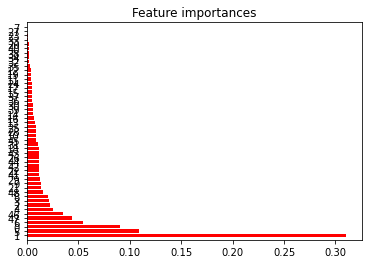

In [ ]:
# plot the feature importance
plt.figure()
plt.title("Feature importances")
plt.barh(range(X_train.shape[1]), importances[indices],
       color="r", xerr=std[indices], align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(X_train.shape[1]), indices)
plt.ylim([-1, X_train.shape[1]])
plt.show()

### Boosting Model

**(i) Run a boosting model with the exponential loss(using ”adaboost” for the argument ”distribution” in the ”gbm” function). Tune the number of trees and the shrinkage factor by five-folder cross-validation. The number of trees is tuned over(100, 200, 500, 1000), and the shrinkage factor is tuned over 0.01 to 0.1 with a step size 0.01.Report the selected tuning parameter values and the corresponding prediction accuracy, sensitivity and specificity on the testing set.**

In [ ]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

In [ ]:
# fit and tune an adaboost classifier
param_grid = [
    # try 8 (4x2) combinations of hyperparameters
    {'n_estimators': [100, 200, 500, 1000], 'learning_rate': [0.01, 0.1]},
  ]
abc = AdaBoostClassifier(random_state=42)
# train across 5 folds, that's a total of ? rounds of training 
grid_search = GridSearchCV(abc, param_grid, cv=5,
                           scoring='accuracy',
                           return_train_score=True)
grid_search.fit(X_train, y_train)

In [ ]:
# show the best parameter
grid_search.best_params_

{'learning_rate': 0.1, 'n_estimators': 1000}

In [ ]:
# Final adaboost model
abc = AdaBoostClassifier(n_estimators=1000, learning_rate=0.1, random_state=42)
model = abc.fit(X_train, y_train)
pred = model.predict(X_test)
cm = confusion_matrix(y_test, pred)
tp = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tn = cm[1][1]
accuracy_score = (tp+tn)/(tp+fp+fn+tn)
sensitivity = tp/(tp+fn)
specificity = tn/(fp+tn)
print("The model has an accuracy of {accu}".format(accu = accuracy_score))
print("The model has a sensitivity score of {sens}".format(sens = sensitivity))
print("The model has a specificity score of {spec}".format(spec = specificity))

The model has an accuracy of 0.9150279193979121
The model has a sensitivity score of 0.9302385892116183
The model has a specificity score of 0.6920152091254753


The adaboost classifier model with the best parameters from the fine tuning has accuracy of 
91.50%, sensitivity of 93.02%, and specificity score of 69.20%, which is pretty high.